# KENYA PERCH CXR WND-CHARM ANALYSIS

## Part 1: Preprocessing intercostal geometry, diagnosis, etc...

August 2015

## Parse tsv files containing intercostal locations

These were converted from the native FIJI *.zip files (which were created by the ROI manager plugin)

In [1]:
pwd

u'/Users/chris/projects/PERCH_Kenya/All_CXR'

In [2]:
from os import walk
root, dirs, files = walk( '.' ).next()

In [3]:
tsvs = [ _ for _ in files if _.endswith('tsv')]

In [5]:
len(tsvs)

492

In [4]:
tiffs = [ _ for _ in files if _.endswith('tif')]

In [6]:
len( tiffs)

492

In [7]:
intercostal_locations = {}
for _file in tsvs:
    patient_id = _file[:-4]
    intercostal_locations[ patient_id ] = []
    with open(_file) as tsv:
        for i, line in enumerate( tsv ):
            columns = line.strip().split('\t')
            # Columns 1 and 2 contain x and y locations of intercostal points
            point = ( int( columns[0] ), int( columns[1] ) )
            intercostal_locations[ patient_id ].append( point )

In [8]:
len(intercostal_locations)

492

### Do all subjects have 22 points?

In [9]:
from collections import Counter

In [10]:
point_count = Counter()
for name, point_list in intercostal_locations.iteritems():
    point_count[ len(point_list) ] += 1

In [11]:
point_count.most_common()

[(22, 472),
 (1, 5),
 (10, 2),
 (13, 2),
 (19, 2),
 (23, 2),
 (6, 1),
 (9, 1),
 (11, 1),
 (16, 1),
 (18, 1),
 (20, 1),
 (21, 1)]

Answer: NOPE!

For now, let's just deal with the 22 point subjects; filter the others out

In [12]:
intercostal_locations = {name : pointlist for name, pointlist in intercostal_locations.iteritems() if len(pointlist) == 22 }

In [13]:
len(intercostal_locations)

472

# calculate individual strip sizes based on relative positioning

In [15]:
quad_iv_intercostals = { name: [ (x, -y) for x,y in pointlist ] for name, pointlist in intercostal_locations.iteritems() }

In [25]:
strip_sizes = {}
for name, pointlist in quad_iv_intercostals.iteritems():
    subject_strip_sizes = []
    leftx, lefty = zip(*pointlist[:11])
    rightx, righty = zip(*pointlist[11:])

    # right side first
    for i in range(11):
        if i == 0:
            h = righty[0] - righty[1]
            w =  rightx[0] - leftx[0]
            subject_strip_sizes.append( (w,h) )
        elif i == 10:
            h = righty[9] - righty[10]
            w = rightx[10] - leftx[10]
            subject_strip_sizes.append( (w,h) )            
        else:
            h = (righty[i-1] - righty[i+1])/2
            w = rightx[i] - leftx[i]           
            subject_strip_sizes.append( (w,h) )

    # now left side
    for i in range(11):
        if i == 0:
            h = lefty[0] - lefty[1]
            w = rightx[0] - leftx[0]
            subject_strip_sizes.append( (w,h) )
        elif i == 10:
            h = lefty[9] - lefty[10]
            w = rightx[10] - leftx[10]
            subject_strip_sizes.append( (w,h) )            
        else:
            h = (lefty[i-1] - lefty[i+1])/2
            w = rightx[i] - leftx[i]
            subject_strip_sizes.append( (w,h) )
    strip_sizes[ name ] = subject_strip_sizes

# Combine strip sizes and intercostal coords into one data frame

In [26]:
import pandas as pd

In [27]:
ic_coords = pd.DataFrame.from_dict( intercostal_locations, orient='index' )

In [28]:
strip_sizes = pd.DataFrame.from_dict( strip_sizes, orient='index' )

In [29]:
len( strip_sizes ) == len( ic_coords)

True

In [30]:
len( strip_sizes )

472

In [31]:
ic_coords['Subject ID'] = ic_coords.index

In [32]:
strip_sizes['Subject ID'] = strip_sizes.index

## Some have letter attached to filename; set these aside for now

In [33]:
ic_coords_no_letter = ic_coords[ [len(name) < 7 for name in ic_coords['Subject ID'] ] ]

In [34]:
len( ic_coords_no_letter)

430

In [35]:
len( set(ic_coords_no_letter['Subject ID']) )

430

In [36]:
strip_sizes_no_letter = strip_sizes[ [len(name) < 7 for name in strip_sizes['Subject ID'] ] ]

In [37]:
len( set(strip_sizes_no_letter['Subject ID']) )

430

# Parse excel spreadsheet where pathology is indicated (created by Wenfeng)

In [38]:
pwd

u'/Users/chris/projects/PERCH_Kenya/All_CXR'

In [39]:
import pandas as pd

In [40]:
df = pd.read_excel( '../Human_locating_abnormal_results_COLETTA_EDIT.xlsx')

In [42]:
len(df)

615

Note the misspelling "Conslusion" in the original file

In [43]:
len( df[ df['Final_conslusion'] == '5 - Uninterpretable'])

29

Drop the uninterpretable

In [44]:
df = df[ df['Final_conslusion'] != '5 - Uninterpretable']

In [45]:
len(df)

586

Remove rows that have a diagnosis but are undrawn

In [46]:
bad = (df['Final_conslusion'] != '4 - Normal') & (df['Draw_in_Folder'] == 'undrawn')

In [47]:
import numpy as np

In [48]:
df = df[ np.logical_not(bad) ]

In [49]:
len(df)

533

remove rows that have multiple calls

In [51]:
grouped = df.groupby( 'Subject ID' )

In [52]:
groups = grouped.__iter__()
unique_df = pd.concat( [ g for l, g in groups if len(g) == 1] )

In [53]:
len(unique_df)

519

## What is population overlap with annotated

In [61]:
have_coords = set( strip_sizes_no_letter['Subject ID'])

In [62]:
len(have_coords)

430

In [63]:
intersection = unique_df[ [ name in have_coords for name in unique_df['Subject ID'] ]]

In [64]:
len(intersection)

403

In [65]:
intersection.Final_conslusion.value_counts()

4 - Normal                           209
2 - Other infiltrate only            115
1 - PEP only                          42
3 - Both PEP and other infiltrate     37
dtype: int64

# Move intersection into dir called training_set

In [ ]:
!mkdir training_set

In [69]:
root, dirs, files = walk( '.' ).next()

In [72]:
len(files)

4476

In [70]:
wanted_subjects = set(intersection['Subject ID'])

In [71]:
import shutil

In [73]:
for _file in files:
    for subjid in wanted_subjects:
        if _file.startswith( subjid ):
            shutil.move( _file, 'training_set')

## Move the rest to reserve

In [74]:
!mkdir reserve

In [75]:
root, dirs, files = walk( '.' ).next()

In [76]:
for _file in files:
    if _file.startswith('K'):
        shutil.move( _file, 'reserve')

## Write the training set related tables to training_set

In [79]:
intersection.to_excel( 'training_set/Human_locating_abnormal_TRAINING_SET.xls')

In [80]:
intersection.to_csv( 'training_set/Human_locating_abnormal_TRAINING_SET.csv')

In [81]:
strip_sizes_intersection = strip_sizes_no_letter[ [name in wanted_subjects for name in strip_sizes_no_letter['Subject ID']]]

In [82]:
len(strip_sizes_intersection)

403

In [83]:
strip_sizes_intersection.to_csv('training_set/strip_sizes.csv')

In [84]:
ic_coords_intersection = ic_coords_no_letter[ [name in wanted_subjects for name in ic_coords_no_letter['Subject ID']]]

In [85]:
len( ic_coords_intersection)

403

In [86]:
ic_coords_intersection.to_csv('training_set/ic_coords.csv')

## Write the remainder metadata into reserve

In [88]:
root, dirs, files = walk( './reserve' ).next()

In [89]:
reserve_tiffs = [ _ for _ in files if _.endswith('tif')]

In [90]:
len(reserve_tiffs)

89

In [92]:
reserve_subjects = set([_[:6] for _ in reserve_tiffs])

In [94]:
len( reserve_subjects )

65

In [95]:
df = pd.read_excel( '../Human_locating_abnormal_results_COLETTA_EDIT.xlsx')

In [96]:
reserve_df = df[ [ subj in reserve_subjects for subj in df['Subject ID'] ] ]

In [97]:
len(reserve_df)

67

In [98]:
reserve_df

,Subject ID,CXR_ID,Draw_in_Folder,Final_conslusion,Note,Tile_1,Tile_2,Tile_3,Tile_4,Tile_5,...,Tile_13,Tile_14,Tile_15,Tile_16,Tile_17,Tile_18,Tile_19,Tile_20,Tile_21,Tile_22
8,K00949,K00949-AP,1,1 - PEP only,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,NaN,NaN,NaN,NaN
9,K01020,K01020-AP,1,1 - PEP only,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,K02318,K02318-AP,1,1 - PEP only,NaN,2,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,K02345,K02345-AP,1,1 - PEP only,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN
21,K03455,K03455-AP,undrawn,1 - PEP only,Unable to locate abnormal,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,K03922,K03922-AP,1,1 - PEP only,NaN,NaN,NaN,NaN,NaN,NaN,...,2,1,1,1,1,1,1,1,NaN,NaN
28,K04268,K04268-AP,1,1 - PEP only,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,1,1,1,1,1,NaN,NaN
31,K04661,K04661-AP,1,1 - PEP only,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,NaN,NaN,NaN
32,K04661,K04661-AP_02,1,1 - PEP only,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,NaN,NaN,NaN
34,K04861,K04861-AP,1,1 - PEP only,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [393]:
reserve_df.to_csv('reserve_diagnosis.csv')

# Continue on with training_set

Drop the columns/ modify headers to become row values

In [103]:
intersection.columns

Index([      u'Subject ID',           u'CXR_ID',   u'Draw_in_Folder',
       u'Final_conslusion',             u'Note',           u'Tile_1',
                 u'Tile_2',           u'Tile_3',           u'Tile_4',
                 u'Tile_5',           u'Tile_6',           u'Tile_7',
                 u'Tile_8',           u'Tile_9',          u'Tile_10',
                u'Tile_11',          u'Tile_12',          u'Tile_13',
                u'Tile_14',          u'Tile_15',          u'Tile_16',
                u'Tile_17',          u'Tile_18',          u'Tile_19',
                u'Tile_20',          u'Tile_21',          u'Tile_22'],
      dtype='object')

In [104]:
new_headers = []
for header in intersection.columns:
    if 'Tile_' in header:
        new_headers.append( header[5:] )
    else:
        new_headers.append( header )  

In [105]:
intersection.columns = new_headers

In [106]:
intersection.columns

Index([      u'Subject ID',           u'CXR_ID',   u'Draw_in_Folder',
       u'Final_conslusion',             u'Note',                u'1',
                      u'2',                u'3',                u'4',
                      u'5',                u'6',                u'7',
                      u'8',                u'9',               u'10',
                     u'11',               u'12',               u'13',
                     u'14',               u'15',               u'16',
                     u'17',               u'18',               u'19',
                     u'20',               u'21',               u'22'],
      dtype='object')

In [107]:
intersection = intersection.drop( '1', 1 ).drop('2', 1).drop('10', 1).drop('11', 1).drop('12', 1).drop('13', 1).drop('21',1).drop('22',1)

In [108]:
intersection.head()

,Subject ID,CXR_ID,Draw_in_Folder,Final_conslusion,Note,3,4,5,6,7,8,9,14,15,16,17,18,19,20
303,K00002,NaN,undrawn,4 - Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,K00032,NaN,undrawn,4 - Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,K00055,K00055-AP,3,2 - Other infiltrate only,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,K00069,NaN,undrawn,4 - Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,K00086,K00086-AP,1,1 - PEP only,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Use Pandas' melt() function to turn intercostal location columns into rows

In [36]:
pd.melt?

In [109]:
intersection = pd.melt( intersection, var_name='intercostal_position', value_name='diagnosis', id_vars=('Subject ID', 'CXR_ID', 'Draw_in_Folder', 'Final_conslusion','Note') )

In [110]:
intersection.head()

,Subject ID,CXR_ID,Draw_in_Folder,Final_conslusion,Note,intercostal_position,diagnosis
0,K00002,NaN,undrawn,4 - Normal,NaN,3,NaN
1,K00032,NaN,undrawn,4 - Normal,NaN,3,NaN
2,K00055,K00055-AP,3,2 - Other infiltrate only,NaN,3,NaN
3,K00069,NaN,undrawn,4 - Normal,NaN,3,NaN
4,K00086,K00086-AP,1,1 - PEP only,NaN,3,NaN


In [111]:
intersection = intersection.convert_objects(convert_numeric=True)

In [112]:
intersection.head()

,Subject ID,CXR_ID,Draw_in_Folder,Final_conslusion,Note,intercostal_position,diagnosis
0,K00002,NaN,NaN,4 - Normal,NaN,3,NaN
1,K00032,NaN,NaN,4 - Normal,NaN,3,NaN
2,K00055,K00055-AP,3,2 - Other infiltrate only,NaN,3,NaN
3,K00069,NaN,NaN,4 - Normal,NaN,3,NaN
4,K00086,K00086-AP,1,1 - PEP only,NaN,3,NaN


In [113]:
intersection.dtypes

Subject ID               object
CXR_ID                   object
Draw_in_Folder          float64
Final_conslusion         object
Note                    float64
intercostal_position      int64
diagnosis               float64
dtype: object

In [114]:
intersection = intersection.sort( ['Final_conslusion', 'Subject ID', 'intercostal_position'])

In [115]:
intersection

,Subject ID,CXR_ID,Draw_in_Folder,Final_conslusion,Note,intercostal_position,diagnosis
4,K00086,K00086-AP,1,1 - PEP only,NaN,3,NaN
407,K00086,K00086-AP,1,1 - PEP only,NaN,4,1
810,K00086,K00086-AP,1,1 - PEP only,NaN,5,1
1213,K00086,K00086-AP,1,1 - PEP only,NaN,6,NaN
1616,K00086,K00086-AP,1,1 - PEP only,NaN,7,NaN
2019,K00086,K00086-AP,1,1 - PEP only,NaN,8,NaN
2422,K00086,K00086-AP,1,1 - PEP only,NaN,9,NaN
2825,K00086,K00086-AP,1,1 - PEP only,NaN,14,NaN
3228,K00086,K00086-AP,1,1 - PEP only,NaN,15,NaN
3631,K00086,K00086-AP,1,1 - PEP only,NaN,16,NaN


Reindex

In [116]:
intersection.index = range(len(intersection))

In [160]:
intersection.head()

,Subject ID,CXR_ID,Draw_in_Folder,Final_conslusion,Note,intercostal_position,diagnosis
0,K00086,K00086-AP,1,1 - PEP only,NaN,3,NaN
1,K00086,K00086-AP,1,1 - PEP only,NaN,4,1
2,K00086,K00086-AP,1,1 - PEP only,NaN,5,1
3,K00086,K00086-AP,1,1 - PEP only,NaN,6,NaN
4,K00086,K00086-AP,1,1 - PEP only,NaN,7,NaN


# Merge geometry and diagnosis info into 1 data frame

In [121]:
ic_coords_intersection = ic_coords_intersection.copy(deep=True)

In [122]:
ic_coords_intersection.index

Index([u'K03144', u'K01365', u'K01366', u'K02316', u'K05968', u'K04647',
       u'K00503', u'K04164', u'K04389', u'K00984', 
       ...
       u'K03798', u'K01186', u'K04012', u'K02816', u'K05267', u'K05261',
       u'K00368', u'K03408', u'K03365', u'K00361'],
      dtype='object', length=403)

In [123]:
len(ic_coords_intersection)

403

In [124]:
ic_coords_intersection['Subject ID'] = ic_coords_intersection.index

## make the headers match the other data frame

In [125]:
ic_coords_intersection.columns

Index([            0,             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,            10,            11,
                  12,            13,            14,            15,
                  16,            17,            18,            19,
                  20,            21, u'Subject ID'],
      dtype='object')

In [127]:
ic_coords_intersection.columns = pd.Int64Index( range(1,24))

In [128]:
ic_coords_intersection.columns

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23],
           dtype='int64')

## drop the unused strip locations

In [129]:
ic_coords_intersection= ic_coords_intersection.drop( 1, 1 ).drop(2, 1).drop(10, 1).drop(11, 1).drop(12, 1).drop(13, 1).drop(21,1).drop(22,1).drop(23,1)

In [161]:
ic_coords_intersection.head()

,Subject ID,intercostal_position,intercostal_coord
391,K00002,3,"(762, 984)"
794,K00002,4,"(760, 1034)"
1197,K00002,5,"(754, 1080)"
1600,K00002,6,"(746, 1130)"
2003,K00002,7,"(740, 1182)"


## turn columns into rows

In [132]:
ic_coords_intersection['Subject ID'] = ic_coords_intersection.index

In [134]:
ic_coords_intersection = pd.melt( ic_coords_intersection, var_name='intercostal_position', value_name='intercostal_coord', id_vars=('Subject ID') )

In [136]:
ic_coords_intersection = ic_coords_intersection.sort( ['Subject ID','intercostal_position', ])

In [138]:
len( ic_coords_intersection)

5642

In [139]:
len(intersection)

5642

# Now load strip sizes

In [140]:
len(strip_sizes_intersection)

403

In [144]:
strip_sizes_intersection = strip_sizes_intersection.drop('Subject ID', 1)

In [145]:
strip_sizes_intersection.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19, 20, 21],
           dtype='int64')

In [146]:
strip_sizes_intersection.columns = pd.Int64Index( range(1,23))

In [148]:
strip_sizes_intersection.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21, 22],
           dtype='int64')

In [149]:
strip_sizes_intersection = strip_sizes_intersection.drop( 1, 1 ).drop(2, 1).drop(10, 1).drop(11, 1).drop(12, 1).drop(13, 1).drop(21,1).drop(22,1)

In [151]:
strip_sizes_intersection.index

Index([u'K03144', u'K01365', u'K01366', u'K02316', u'K05968', u'K04647',
       u'K00503', u'K04164', u'K04389', u'K00984', 
       ...
       u'K03798', u'K05616', u'K04012', u'K02816', u'K05267', u'K05261',
       u'K00368', u'K03408', u'K03365', u'K00361'],
      dtype='object', length=403)

In [152]:
strip_sizes_intersection['Subject ID'] = strip_sizes_intersection.index

In [153]:
strip_sizes_intersection.head()

,3,4,5,6,7,8,9,14,15,16,17,18,19,20,Subject ID
K03144,"(346, 46)","(366, 43)","(384, 45)","(396, 46)","(406, 50)","(420, 61)","(438, 69)","(346, 48)","(366, 50)","(384, 50)","(396, 50)","(406, 53)","(420, 66)","(438, 74)",K03144
K01365,"(352, 45)","(388, 45)","(420, 47)","(442, 54)","(462, 60)","(468, 72)","(494, 92)","(352, 45)","(388, 43)","(420, 39)","(442, 39)","(462, 45)","(468, 50)","(494, 59)",K01365
K01366,"(444, 60)","(470, 57)","(490, 59)","(522, 69)","(550, 79)","(586, 95)","(626, 106)","(444, 59)","(470, 54)","(490, 56)","(522, 63)","(550, 68)","(586, 85)","(626, 110)",K01366
K02316,"(312, 52)","(342, 52)","(372, 63)","(388, 61)","(408, 60)","(440, 76)","(466, 89)","(312, 49)","(342, 54)","(372, 58)","(388, 59)","(408, 62)","(440, 74)","(466, 87)",K02316
K05968,"(468, 76)","(494, 72)","(522, 74)","(546, 79)","(566, 90)","(598, 106)","(606, 115)","(468, 81)","(494, 78)","(522, 79)","(546, 84)","(566, 95)","(598, 108)","(606, 116)",K05968


In [154]:
strip_sizes_intersection = pd.melt( strip_sizes_intersection, var_name='intercostal_position', value_name='raw_strip_size', id_vars=('Subject ID') )

In [155]:
strip_sizes_intersection = strip_sizes_intersection.sort( ['Subject ID','intercostal_position', ])

In [156]:
strip_sizes_intersection.head()

,Subject ID,intercostal_position,raw_strip_size
391,K00002,3,"(276, 45)"
794,K00002,4,"(288, 44)"
1197,K00002,5,"(306, 44)"
1600,K00002,6,"(324, 48)"
2003,K00002,7,"(340, 51)"


In [157]:
len( ic_coords_intersection)

5642

In [158]:
len( strip_sizes_intersection)

5642

# join all tables

In [209]:
master = pd.merge( ic_coords_intersection, strip_sizes_intersection, on=['Subject ID', 'intercostal_position'])

In [210]:
master = pd.merge(master, intersection, on=['Subject ID', 'intercostal_position'])

In [211]:
len(master)

5642

In [212]:
master.dtypes

Subject ID               object
intercostal_position     object
intercostal_coord        object
raw_strip_size           object
CXR_ID                   object
Draw_in_Folder          float64
Final_conslusion         object
Note                    float64
diagnosis               float64
dtype: object

In [213]:
master.head()

,Subject ID,intercostal_position,intercostal_coord,raw_strip_size,CXR_ID,Draw_in_Folder,Final_conslusion,Note,diagnosis
0,K00002,3,"(762, 984)","(276, 45)",NaN,NaN,4 - Normal,NaN,NaN
1,K00002,4,"(760, 1034)","(288, 44)",NaN,NaN,4 - Normal,NaN,NaN
2,K00002,5,"(754, 1080)","(306, 44)",NaN,NaN,4 - Normal,NaN,NaN
3,K00002,6,"(746, 1130)","(324, 48)",NaN,NaN,4 - Normal,NaN,NaN
4,K00002,7,"(740, 1182)","(340, 51)",NaN,NaN,4 - Normal,NaN,NaN


## Split the coords into their own columns

In [214]:
master['width_raw'] = master['raw_strip_size'].apply( lambda xy: xy[0] )

In [215]:
master['height_raw'] = master['raw_strip_size'].apply( lambda xy: xy[1] )

In [216]:
master.head()

,Subject ID,intercostal_position,intercostal_coord,raw_strip_size,CXR_ID,Draw_in_Folder,Final_conslusion,Note,diagnosis,width_raw,height_raw
0,K00002,3,"(762, 984)","(276, 45)",NaN,NaN,4 - Normal,NaN,NaN,276,45
1,K00002,4,"(760, 1034)","(288, 44)",NaN,NaN,4 - Normal,NaN,NaN,288,44
2,K00002,5,"(754, 1080)","(306, 44)",NaN,NaN,4 - Normal,NaN,NaN,306,44
3,K00002,6,"(746, 1130)","(324, 48)",NaN,NaN,4 - Normal,NaN,NaN,324,48
4,K00002,7,"(740, 1182)","(340, 51)",NaN,NaN,4 - Normal,NaN,NaN,340,51


In [217]:
master = master.drop( 'raw_strip_size', axis=1 )

In [218]:
master.head()

,Subject ID,intercostal_position,intercostal_coord,CXR_ID,Draw_in_Folder,Final_conslusion,Note,diagnosis,width_raw,height_raw
0,K00002,3,"(762, 984)",NaN,NaN,4 - Normal,NaN,NaN,276,45
1,K00002,4,"(760, 1034)",NaN,NaN,4 - Normal,NaN,NaN,288,44
2,K00002,5,"(754, 1080)",NaN,NaN,4 - Normal,NaN,NaN,306,44
3,K00002,6,"(746, 1130)",NaN,NaN,4 - Normal,NaN,NaN,324,48
4,K00002,7,"(740, 1182)",NaN,NaN,4 - Normal,NaN,NaN,340,51


In [219]:
master['x_c'] = master['intercostal_coord'].apply( lambda xy: xy[0] )

In [220]:
master['y_c'] = master['intercostal_coord'].apply( lambda xy: xy[1] )

In [221]:
master = master.drop( 'intercostal_coord', axis=1 )

In [287]:
master.head()

,Subject ID,intercostal_position,CXR_ID,Draw_in_Folder,Final_conslusion,Note,diagnosis,width_raw,height_raw,x_c,y_c,x0_300x50,y0_300x50
0,K00002,3,NaN,NaN,4 - Normal,NaN,CLEAR,276,45,762,984,612,959
1,K00002,4,NaN,NaN,4 - Normal,NaN,CLEAR,288,44,760,1034,610,1009
2,K00002,5,NaN,NaN,4 - Normal,NaN,CLEAR,306,44,754,1080,604,1055
3,K00002,6,NaN,NaN,4 - Normal,NaN,CLEAR,324,48,746,1130,596,1105
4,K00002,7,NaN,NaN,4 - Normal,NaN,CLEAR,340,51,740,1182,590,1157


# save table to CSV

In [175]:
master.to_csv( './training_set/master_KENYA_strip_data.csv')

# Redo 2D histogram with upper and lower strips removed

In [180]:
%matplotlib inline

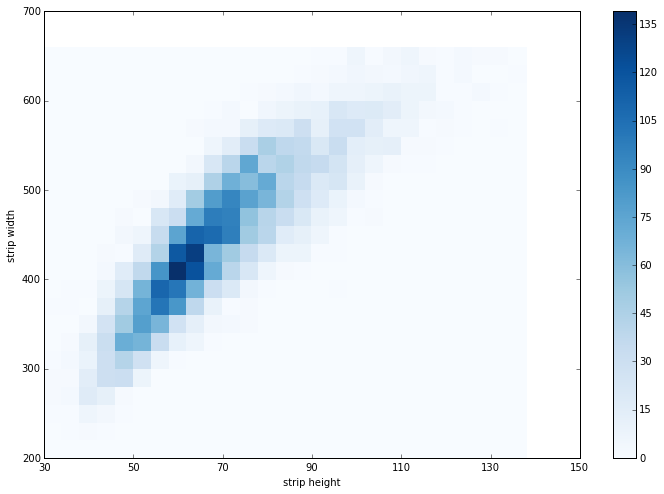

In [233]:
x=tuple( master['width_raw'])
y = tuple( master['height_raw'])
width_bins = range( 200, 800, 25)
height_bins = range( 30, 170, 5)
H, xedges, yedges = np.histogram2d(x,y, bins=[width_bins,height_bins])
import matplotlib.pyplot as plt
import numpy as np
column_labels = xedges
row_labels = yedges
data = H
fig, ax = plt.subplots(figsize=(12,8))
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

#legend
cbar = plt.colorbar(heatmap)

# put the major ticks at the middle of each cell
#ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
#ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(range(30,170,20))
ax.set_yticklabels(range(200,800,100))
ax.set_xlabel('strip height')
ax.set_ylabel('strip width')
plt.show()

# Choose strip dimensions to maximize number of PEP

PEP is the smallest class:

## Change diagnosis from numbers and NaNs to text

In [245]:
master['diagnosis'].fillna( 'CLEAR', inplace=True)

In [246]:
master['diagnosis'].value_counts()

CLEAR    4297
3.0      1058
1.0       253
4.0        18
2.0        16
dtype: int64

In [247]:
master['diagnosis'].replace( 3.0, 'OI', inplace=True)

In [248]:
master['diagnosis'].value_counts()

CLEAR    4297
OI       1058
1.0       253
4.0        18
2.0        16
dtype: int64

In [249]:
master['diagnosis'].replace( 1.0, 'PEP', inplace=True)

In [250]:
master['diagnosis'].value_counts()

CLEAR    4297
OI       1058
PEP       253
4.0        18
2.0        16
dtype: int64

## remove ambiguous

In [251]:
master = master[ master['diagnosis'] != 4.0]

In [252]:
master = master[ master['diagnosis'] != 2.0]

In [253]:
master['diagnosis'].value_counts()

CLEAR    4297
OI       1058
PEP       253
dtype: int64

# PEP location statistics

In [254]:
all_pep = master[ master['diagnosis'] == 'PEP']

In [255]:
all_pep.dtypes

Subject ID               object
intercostal_position     object
CXR_ID                   object
Draw_in_Folder          float64
Final_conslusion         object
Note                    float64
diagnosis                object
width_raw                 int64
height_raw                int64
x_c                       int64
y_c                       int64
x0_300x50                 int64
y0_300x50                 int64
dtype: object

In [256]:
len(all_pep)

253

In [257]:
all_pep.intercostal_position.value_counts()

7     36
5     36
6     31
4     30
8     27
3     21
9     15
19    14
18    11
20     9
17     8
16     7
15     4
14     4
dtype: int64

mostly on the left

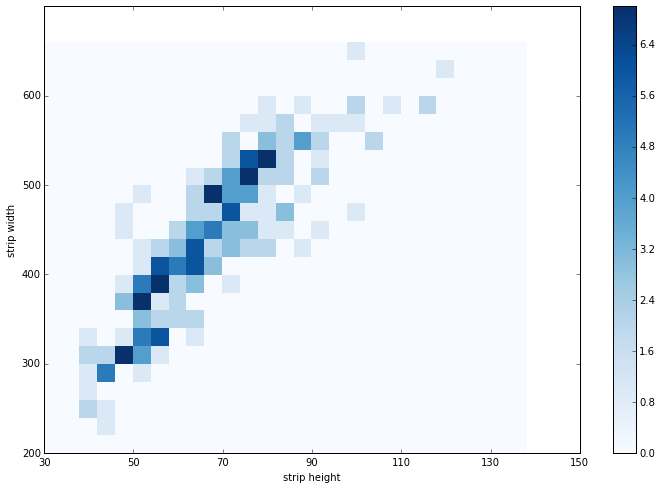

In [258]:
x=tuple( all_pep['width_raw'])
y = tuple( all_pep['height_raw'])
width_bins = range( 200, 800, 25)
height_bins = range( 30, 170, 5)
H, xedges, yedges = np.histogram2d(x,y, bins=[width_bins,height_bins])
import matplotlib.pyplot as plt
import numpy as np
column_labels = xedges
row_labels = yedges
data = H
fig, ax = plt.subplots(figsize=(12,8))
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

#legend
cbar = plt.colorbar(heatmap)

# put the major ticks at the middle of each cell
#ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
#ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(range(30,170,20))
ax.set_yticklabels(range(200,700,100))
ax.set_xlabel('strip height')
ax.set_ylabel('strip width')
plt.show()

# calculate top left coord for bounding box

In [ ]:
import pandas as pd

In [ ]:
master = pd.DataFrame.from_csv( './training_set/master_KENYA_strip_data.csv')

In [330]:
window_width = 350
window_height = 60

In [331]:
master['x0_{}x{}'.format(window_width, window_height)] = master['x_c'].apply( lambda x: x - (window_width/2) )

In [332]:
master['y0_{}x{}'.format(window_width, window_height)] = master['y_c'].apply( lambda x: x - (window_height/2) )

In [333]:
master.head()

,Subject ID,intercostal_position,CXR_ID,Draw_in_Folder,Final_conslusion,Note,diagnosis,width_raw,height_raw,x_c,y_c,x0_300x50,y0_300x50,x0_300x60,y0_300x60,x0_350x50,y0_350x50,x0_350x60,y0_350x60
0,K00002,3,NaN,NaN,4 - Normal,NaN,CLEAR,276,45,762,984,612,959,612,954,587,959,587,954
1,K00002,4,NaN,NaN,4 - Normal,NaN,CLEAR,288,44,760,1034,610,1009,610,1004,585,1009,585,1004
2,K00002,5,NaN,NaN,4 - Normal,NaN,CLEAR,306,44,754,1080,604,1055,604,1050,579,1055,579,1050
3,K00002,6,NaN,NaN,4 - Normal,NaN,CLEAR,324,48,746,1130,596,1105,596,1100,571,1105,571,1100
4,K00002,7,NaN,NaN,4 - Normal,NaN,CLEAR,340,51,740,1182,590,1157,590,1152,565,1157,565,1152


# create wndcharm file of files with crop info

## Separate FOF for strips coming from CXRs that are clear

In [334]:
clear_only = master[ master['Final_conslusion'] == '4 - Normal']

In [335]:
len(clear_only)

2926

In [336]:
master['diagnosis'].value_counts()

CLEAR    4297
OI       1058
PEP       253
dtype: int64

In [337]:
clear_only['diagnosis'].value_counts()

CLEAR    2926
dtype: int64

In [338]:
len(clear_only)

2926

In [339]:
clear_only.head()

,Subject ID,intercostal_position,CXR_ID,Draw_in_Folder,Final_conslusion,Note,diagnosis,width_raw,height_raw,x_c,y_c,x0_300x50,y0_300x50,x0_300x60,y0_300x60,x0_350x50,y0_350x50,x0_350x60,y0_350x60
0,K00002,3,NaN,NaN,4 - Normal,NaN,CLEAR,276,45,762,984,612,959,612,954,587,959,587,954
1,K00002,4,NaN,NaN,4 - Normal,NaN,CLEAR,288,44,760,1034,610,1009,610,1004,585,1009,585,1004
2,K00002,5,NaN,NaN,4 - Normal,NaN,CLEAR,306,44,754,1080,604,1055,604,1050,579,1055,579,1050
3,K00002,6,NaN,NaN,4 - Normal,NaN,CLEAR,324,48,746,1130,596,1105,596,1100,571,1105,571,1100
4,K00002,7,NaN,NaN,4 - Normal,NaN,CLEAR,340,51,740,1182,590,1157,590,1152,565,1157,565,1152


In [340]:
clear_iter = clear_only.iterrows()

In [341]:
frmt = '{{x={};y={};w={};h={}}}'

In [342]:
clear_fof_rows = []
for _, row in clear_iter:
    subj_id = row['Subject ID']
    subj_name = subj_id + '-' + str(row['intercostal_position'])
    _path = subj_id + '-CXR.tif'
    _class = row['diagnosis']
    x0 = row['x0_{}x{}'.format(window_width, window_height)]
    y0 = row['y0_{}x{}'.format(window_width, window_height)]
    w = window_width
    h = window_height
    sampling_opts = frmt.format( x0, y0, w, h)
    clear_fof_rows.append( '\t'.join( [subj_name, _class, _path, sampling_opts]))

In [343]:
with open( 'training_set/KENYA_CXR_CLEAR_ONLY_{}x{}.fof'.format(window_width, window_height), 'w') as fof:
    for _ in clear_fof_rows:
        fof.write( _ + '\n')

In [344]:
len( clear_fof_rows )

2926

# create separate fof for case

In [345]:
case = master[ master['Final_conslusion'] != '4 - Normal']

In [346]:
len(case)

2682

In [347]:
case_iter = case.iterrows()

In [348]:
case_fof_rows = []
for _, row in case_iter:
    subj_id = row['Subject ID']
    subj_name = subj_id + '-' + str(row['intercostal_position'])
    _path = subj_id + '-CXR.tif'
    _class = row['diagnosis']
    x0 = row['x0_{}x{}'.format(window_width, window_height)]
    y0 = row['y0_{}x{}'.format(window_width, window_height)]
    w = window_width
    h = window_height
    sampling_opts = frmt.format( x0, y0, w, h)
    case_fof_rows.append( '\t'.join( [subj_name, _class, _path, sampling_opts]))

In [349]:
len( case_fof_rows)

2682

In [350]:
with open( 'training_set/KENYA_CXR_CASE_{}x{}.fof'.format(window_width, window_height), 'w') as fof:
    for _ in case_fof_rows:
        fof.write( _ + '\n')

# Create subset that avoids strips with raw strip sizes les than 300x60

# Process reserve

In [351]:
cd reserve/

/Users/chris/projects/PERCH_Kenya/All_CXR/reserve


In [361]:
pwd

u'/Users/chris/projects/PERCH_Kenya/All_CXR/reserve'

In [385]:
root, dirs, files = walk('/Users/chris/projects/PERCH_Kenya/All_CXR/reserve/').next()
print root

/Users/chris/projects/PERCH_Kenya/All_CXR/reserve/


In [386]:
len(files)

344

In [387]:
tiffs = [ _ for _ in files if _.endswith('.tif')]

In [388]:
len(tiffs)

89

In [389]:
tsvs = [ _ for _ in files if _.endswith('.tsv')]

In [390]:
len(tsvs)

89

In [415]:
reserve_df = pd.read_excel( '../../Human_locating_abnormal_results_COLETTA_EDIT.xlsx')

In [406]:
reserve_ic_locs = {}
for _file in tsvs:
    patient_id = _file[:-4]
    reserve_ic_locs[ patient_id ] = []
    with open(_file) as tsv:
        for i, line in enumerate( tsv ):
            columns = line.strip().split('\t')
            # Columns 1 and 2 contain x and y locations of intercostal points
            point = ( int( columns[0] ), int( columns[1] ) )
            reserve_ic_locs[ patient_id ].append( point )
    if len(reserve_ic_locs[ patient_id ]) < 22:
        del reserve_ic_locs[ patient_id ]

In [407]:
len(reserve_ic_locs)

71

In [408]:
reserve_ic_locs = pd.DataFrame.from_dict( reserve_ic_locs, orient='index')

In [409]:
reserve_ic_locs.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
K00857,"(824, 652)","(802, 700)","(796, 758)","(790, 808)","(790, 852)","(788, 908)","(776, 972)","(768, 1034)","(752, 1094)","(734, 1182)",...,"(1158, 670)","(1184, 738)","(1204, 796)","(1230, 852)","(1244, 910)","(1266, 988)","(1278, 1070)","(1294, 1162)","(1290, 1264)","(1270, 1372)"
K03922d,"(728, 546)","(654, 610)","(600, 702)","(552, 794)","(532, 882)","(516, 970)","(488, 1076)","(452, 1188)","(406, 1322)","(386, 1476)",...,"(1126, 684)","(1148, 786)","(1164, 880)","(1176, 976)","(1178, 1064)","(1178, 1156)","(1196, 1272)","(1210, 1414)","(1204, 1568)","(1146, 1684)"
K03922e,"(870, 708)","(802, 774)","(760, 854)","(728, 932)","(706, 1012)","(696, 1090)","(680, 1184)","(662, 1276)","(652, 1406)","(658, 1500)",...,"(1152, 870)","(1158, 954)","(1168, 1020)","(1160, 1076)","(1166, 1148)","(1160, 1212)","(1168, 1286)","(1168, 1366)","(1180, 1464)","(1186, 1570)"
K04165a,"(754, 1050)","(754, 1088)","(750, 1138)","(746, 1186)","(738, 1234)","(726, 1286)","(712, 1336)","(692, 1400)","(670, 1482)","(664, 1570)",...,"(1070, 1068)","(1082, 1122)","(1088, 1176)","(1106, 1230)","(1112, 1288)","(1128, 1342)","(1146, 1406)","(1172, 1496)","(1166, 1608)","(1132, 1688)"
K03922a,"(767, 255)","(711, 323)","(686, 395)","(671, 464)","(651, 532)","(632, 607)","(623, 687)","(599, 779)","(583, 872)","(584, 976)",...,"(1111, 346)","(1127, 428)","(1139, 496)","(1144, 562)","(1152, 630)","(1154, 700)","(1162, 788)","(1166, 880)","(1167, 996)","(1151, 1104)"


In [410]:
reserve_ic_locs['Subject ID']= [ name[:6] for name in reserve_ic_locs.index ]

In [412]:
unique_subj_ids = set(reserve_ic_locs['Subject ID'])

In [413]:
len(unique_subj_ids)

49

In [417]:
reserve_df = reserve_df[ [ subjid in unique_subj_ids for subjid in reserve_df['Subject ID']] ]

In [418]:
len(reserve_df)

51

In [426]:
reserve_df['Draw_in_Folder'].value_counts()

undrawn    33
1          10
2           4
1&2         1
1&2&4       1
1&4         1
4           1
dtype: int64

In [438]:
reserve_df['Final_conslusion'].value_counts()

1 - PEP only                         12
3 - Both PEP and other infiltrate     3
2 - Other infiltrate only             3
dtype: int64

In [427]:
reserve_df = reserve_df[ reserve_df['Draw_in_Folder'] != 'undrawn']

In [428]:
len(reserve_df)

18

In [429]:
unique_subj_ids = set(reserve_df['Subject ID'])

In [431]:
reserve_ic_locs = reserve_ic_locs[ [name in unique_subj_ids for name in reserve_ic_locs['Subject ID']] ]

In [456]:
reserve_ic_locs.columns

Index([            0,             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,            10,            11,
                  12,            13,            14,            15,
                  16,            17,            18,            19,
                  20,            21, u'Subject ID'],
      dtype='object')

In [432]:
len(reserve_ic_locs)

30

In [439]:
reserve_list = []

In [433]:
subj_iter = iter( sorted(unique_subj_ids) )

In [434]:
subjid = subj_iter.next()

In [435]:
print subjid

K00949


In [440]:
locs = reserve_ic_locs[ reserve_ic_locs['Subject ID'] == subjid ]

In [441]:
locs

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,Subject ID
K00949c,"(677, 644)","(636, 700)","(601, 769)","(589, 835)","(568, 900)","(568, 969)","(552, 1041)","(525, 1139)","(528, 1232)","(537, 1349)",...,"(1001, 804)","(1016, 860)","(1018, 921)","(1028, 985)","(1038, 1060)","(1054, 1151)","(1068, 1256)","(1050, 1361)","(1036, 1464)",K00949
K00949d,"(718, 456)","(684, 518)","(668, 588)","(660, 656)","(650, 718)","(642, 780)","(634, 846)","(626, 924)","(622, 1028)","(640, 1134)",...,"(1072, 568)","(1094, 622)","(1108, 684)","(1126, 748)","(1142, 824)","(1166, 910)","(1184, 1016)","(1194, 1136)","(1194, 1244)",K00949


In [452]:
wanted_locs = locs[[False, True]]

In [453]:
wanted_locs

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,Subject ID
K00949d,"(718, 456)","(684, 518)","(668, 588)","(660, 656)","(650, 718)","(642, 780)","(634, 846)","(626, 924)","(622, 1028)","(640, 1134)",...,"(1072, 568)","(1094, 622)","(1108, 684)","(1126, 748)","(1142, 824)","(1166, 910)","(1184, 1016)","(1194, 1136)","(1194, 1244)",K00949


In [442]:
calls = reserve_df[ reserve_df['Subject ID'] == subjid ]

In [443]:
calls

,Subject ID,CXR_ID,Draw_in_Folder,Final_conslusion,Note,Tile_1,Tile_2,Tile_3,Tile_4,Tile_5,...,Tile_13,Tile_14,Tile_15,Tile_16,Tile_17,Tile_18,Tile_19,Tile_20,Tile_21,Tile_22
8,K00949,K00949-AP,1,1 - PEP only,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,NaN,NaN,NaN,NaN


In [454]:
locs_melted = pd.melt( wanted_locs, var_name='intercostal_position', value_name='raw_strip_size', id_vars=('Subject ID') )

In [455]:
locs_melted

,Subject ID,intercostal_position,raw_strip_size
0,K00949,0,"(718, 456)"
1,K00949,1,"(684, 518)"
2,K00949,2,"(668, 588)"
3,K00949,3,"(660, 656)"
4,K00949,4,"(650, 718)"
5,K00949,5,"(642, 780)"
6,K00949,6,"(634, 846)"
7,K00949,7,"(626, 924)"
8,K00949,8,"(622, 1028)"
9,K00949,9,"(640, 1134)"


# Calculate features

In [84]:
from wndcharm.FeatureSpace import FeatureSpace
import pdb; pdb.set_trace()
fs = FeatureSpace.NewFromFileOfFiles('KENYA_CXR_CASE.fof', long=True, quiet=False)
fs.ToFitFile( 'KENYA_CXR_CASE.fit' )